# This sandbox creates the simulation environment

## Trajectory Data
- live real-time feed
- historical archive
- ~~artificial~~

## Route Type
- topology
- ~~map~~

## Classes
- Stop
- Link
- Bus
- ~~Pax: with OD~~

## Link Travel Time/Speed
### fixed route characteristics
- stops
- signals
- intersections
- road design

### dynamic route characteristics
- base demand (neighborhood)
- base traffic
- weather
- time (hour, day, month)

### operation characteristics
- driver behavior
- operation constraints

## Dwelling Time
- vehicle (type, door, stair, seats)
- occupancy
- rider behavior
- OD pairs

## Visualization
- object-oriented interaction
- user interface
- timer
- event log
- traffic conditions
- weather
- time (e.g., weekday, peak hour)
- reality
- counter-factual

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

from IPython.display import display, clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from buskit import simulator as bsim

In [75]:
# determine data source
beta = True
time_coef = 100000 # simulation time is __ times faster than the reality
avg_door_t = 5 # assume opening and closing the door take 5 seconds in total
avg_board_t = 3 # assume each boarding takes 3 sec
avg_alight_t = 2 # assume each alight takes 2 sec

if beta:
    # artificial data   ### make this part automatized with given number of stop
    stop_ref = np.array([1, 2, 3, 4, 5, 6, 7])
    stop_pos = np.array([0, 100, 200, 300, 400, 500, 600])
    stop_name = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
else:
    # historical data
    stop_ref, stop_pos, stop_name = bsim.read_data("MTA_data/M1-Tue-180410-154415-260.csv", 1)

# speed and travel time data are currently artificial
link_vel = 1.5 * np.random.randn(len(stop_pos)) + 7 # make sure the unit is m/sec
#dwell_t = 7 * np.random.randn(len(stop_pos)) + 20 # make sure the unit is sec

# pax distribution
stop_pos_next = np.append(stop_pos, stop_pos[-1])[1:]

pos_mu = stop_pos.mean()
pos_std = stop_pos.std()
pax_norm = ss.norm(loc=pos_mu, scale=pos_std)
pax_perc = np.array([pax_norm.cdf(stop_pos_next[i]) - pax_norm.cdf(stop_pos[i]) for i in range(len(stop_pos))]) ### a temporary measure ###

pax_hr_route = 5000
pax_hr_stop = pax_hr_route * pax_perc
pax_at_stop = np.zeros(len(stop_pos))

In [88]:
# Bus class
class Bus(object):
    
    capacity = 60
    seat = 40
    
    def __init__(self, ref, pos=0):
        self.ref = ref # vehicle reference
        self.pos = pos # vehicle location (1-D)
        self.link = np.sum(self.pos >= stop_pos) - 1 # link index starts from 0  ### unified with the formula in Stop Class
        self.vel = link_vel[self.link] # speed at current link
        self.next_stop = stop_pos[self.link + 1] # position of next stop
        self.dwell_t = 0
        self.pax = 0
        self.clock = 0
        self.operate = True
        self.atstop = False
        
        self.log_pos = [self.pos]
        self.log_vel = [self.vel]
        self.log_pax = [0]
        self.log_dwell = [0]

    def terminal(self):
        print("The bus has reached the terminal")
        self.operate = False
        self.vel = 0
        self.pax = 0
        
    def stop(self):
        print("Bus %s is making a stop at %s (position %i)"%(self.ref, stop_name[self.link + 1], self.next_stop))
        self.atstop = True
        self.pax_to_board = pax_at_stop[self.link + 1] # check how many pax at stop
        self.board_t = self.pax * avg_board_t
        self.alight_t = 0 * avg_alight_t  #### TO DEVELOP
        self.dwell_t = avg_door_t + self.alight_t + self.board_t # supposed to dwell for this long
        self.clock += 1

#         self.vel = 0
#         self.pos += self.vel
        self.record()

    def move(self):
        pax_at_stop[self.link + 1] = 0 # clear all pax at stop
        self.log_dwell.append(self.dwell_t)
        # move on!
        self.atstop = False
        self.dwell_t = 0
        self.clock = 0
        self.link += 1
        self.pax = 0 # update pax onboard ###################
        self.record()
        self.vel = link_vel[self.link] # new link speed
        self.next_stop = stop_pos[self.link + 1] # new next stop

    def record(self):
        self.log_pos.append(self.pos)
        self.log_pax.append(self.pax)
        
    def proceed(self):
        if self.operate:
            if self.pos + self.vel >= stop_pos[-1]:
                self.terminal()
            elif self.pos + self.vel >= self.next_stop:  ### this judgement restricts from recording vel as 0 at stop, change to sth else
                self.stop()
                if self.clock >= self.dwell_t:
                    self.move()
            else:
                print("Current position of bus %s: %i"%(self.ref, self.pos))
                self.pos += self.vel
                self.record()
        else:
            print("Bus %s is not operating."%(self.ref))

In [83]:
class Stop(object):
    
    pos_mu = stop_pos.mean()
    pos_std = stop_pos.std()
    pos_len = np.diff(stop_pos) # segment length starting from link 0

    def __init__(self, i):
        self.ref = stop_ref[i] # stop reference
        self.pos = stop_pos[i] # stop location (1-D)
        self.name = stop_name[i] # stop name
        self.link = i # the link (index from 0) that the stop belongs to
#         self.link = list(stop_ref).index(self.ref) # link index starts from 0
        self.pax = 0
        self.first = self.pos == stop_pos[0]
        self.last = self.pos == stop_pos[-1]
        self.clock = 0
        self.log_pax = [0]
        self.log_wait_t = [0]
#        self.log_msg = []
#        self.log_spacing

    def new_pax(self): # randomly generate new pax each second
        # future function, also consider bus frequency to determine arrival distribution
        # frequent services tend to have uniform arrivals
        return int(np.random.poisson(lam=(pax_hr_stop[self.link]/3600), size=1))  # lambda = (avg pax/hr) / sec
    
    def update(self):
        self.clock += 1
        self.pax += self.new_pax()
        pax_at_stop[self.link] = self.pax # update global listing of pax at each stop
        return self.pax

    def record(self):
        self.log_pax.append(self.pax)
        self.log_wait_t.append(self.clock)

    def proceed(self):
        if pax_at_stop[self.link] < self.pax: # if pax are cleared by a bus
            self.pax = pax_at_stop[self.link] # reverse update
            self.clock = 0

        self.update()
        self.record()

In [99]:
bus1 = Bus('7609', 0)
bus2 = Bus('7828', 120)
bus3 = Bus('7964', 290)
buses = [bus1, bus2, bus3]

In [97]:
stop1 = Stop(0)
stop2 = Stop(1)
stop3 = Stop(2)
stop4 = Stop(3)
stop5 = Stop(4)
stop6 = Stop(5)
stop7 = Stop(6)
stops = [stop1, stop2, stop3, stop4,
         stop5, stop6, stop7]

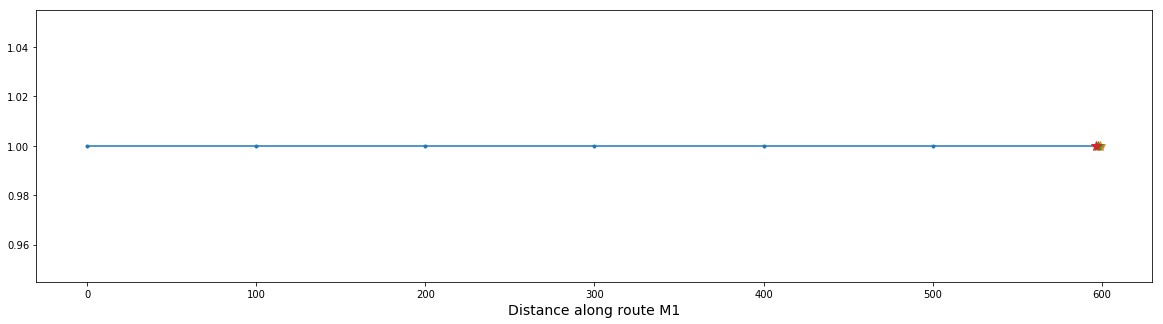

Time elapsed: 121 seconds
Pax at each stop:  [25. 22. 19. 21. 12.  3.  0.]


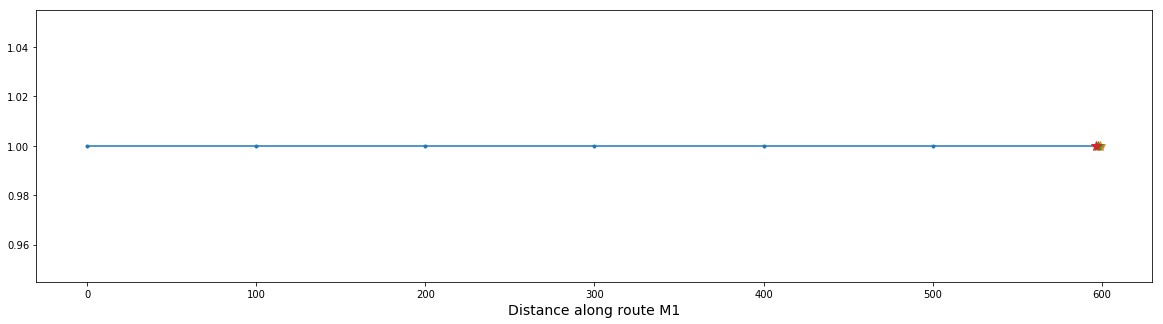

In [100]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

### FLATTEN THE CODE HERE!!! ###
ax.plot(stop_pos, np.ones(len(stop_pos)), '.-')
veh1, = ax.plot(bus1.pos, 1, '*', markersize=10)
veh2, = ax.plot(bus2.pos, 1, '*', markersize=10)
veh3, = ax.plot(bus3.pos, 1, '*', markersize=10)

ax.set_xlabel('Distance along route M1', fontsize=14)

clock = 0

while bus1.operate or bus2.operate or bus3.operate:
    [s.proceed() for s in stops]
    [b.proceed() for b in buses]

    veh1.set_xdata(bus1.pos)
    veh2.set_xdata(bus2.pos)
    veh3.set_xdata(bus3.pos)
    clear_output(wait=True)
    display(fig)
    clock += 1
    print("Time elapsed: %i seconds"%(clock))
    print("Pax at each stop: ", pax_at_stop)
    time.sleep(1/time_coef) # set a global time equivalent parameter

# Next tasks
1. scale up: group generation given bus and stop data

In [ ]:
def spacing():
    for pair in spacing_vars:
        a = df.loc[i,"pos_" + pair.split("_")[1]]
        b = df.loc[i,"pos_" + pair.split("_")[2]]
        val = min(
            abs(a-b),
            ((stop_positions[-1] - max(a,b)) + min(a,b))
            )
        df.loc[i,pair] = val

In [ ]:
def bunching():
    bunch_list = []
    for pair in spacing_vars:
        bunch_list.append(df.loc[i,pair] < 0.03)
    if any(bunch_list):
        df.loc[i,"bunching"] = 1.0
    else:
        df.loc[i,"bunching"] = 0.0

In [ ]:
# TOTAL PAX WAIT
analytics_list=[]
wait_list = []
for v in pax_vars:
    wait_list.append(df[v].sum())

print("TOTAL WAIT: " + str(sum(wait_list)))
analytics_list.append(sum(wait_list))

In [ ]:
if len(df.bunching[df.bunching == 1]) > 0:
    print("TIME OF FIRST BUNCH: " + str(min(df.bunching[df.bunching == 1].index)))
    analytics_list.append(min(df.bunching[df.bunching == 1].index))
else:
    analytics_list.append("no bunch")

In [ ]:
loops = 0
for i in range(1,len(df)):
    for bus in pos_vars:
        if (df.loc[i-1,bus] <= 1.23) and (df.loc[i,bus] >= 1.23):
            loops += 1

print("ROUTES COMPLETED: " + str(loops))
analytics_list.append(loops)

In [ ]:
#Time-Space Diagram
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for i in pos_vars:
    plt.plot(df[i])
plt.ylabel('Position')
plt.xlabel('Time (seconds)')
plt.legend(["Bus 1","Bus 2","Bus 3"])

plt.subplot(2,1,2)
for i in spacing_vars:
    plt.plot(df[i])
plt.ylabel('Spacing')
plt.xlabel('Time (seconds)')
plt.legend(["Between Bus 1 and 2","Between Bus 2 and 3","Between Bus 3 and 1"])

plt.show()

In [ ]:
#Cumulative Arrival Curves
plt.figure(figsize=(20,10))
for i in pax_vars:
    plt.subplot(len(pax_vars),1,pax_vars.index(i)+1)
    plt.title("Stop " + str(pax_vars.index(i)), loc="left")
    plt.plot(df[i])
    plt.ylabel('Number Waiting')
    plt.ylim(ymin = 0, ymax = 15)
    plt.xlabel('Time (seconds)')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
for i in pos_vars:
    plt.plot(df[i])
plt.ylabel('Position')
plt.xlabel('Time (seconds)')
plt.legend(["Bus 1","Bus 2","Bus 3"])


plt.subplot(3,1,2)
for i in spacing_vars:
    plt.plot(df[i])
plt.ylabel('Spacing')
plt.xlabel('Time (seconds)')
plt.legend(["Between Bus 1 and 2","Between Bus 2 and 3","Between Bus 3 and 1"])


plt.subplot(3,1,3)
plt.plot(df.bunching)
plt.ylim(ymin = -0.5, ymax = 1.5)

plt.show()

In [578]:
def check_atstop(buses):
    for b in buses:
        if b.atstop:
            atstop[b.ref] = b.link + 1
        else:
            try:
                atstop.pop(b.ref)
            except KeyError:
                pass
    return atstop

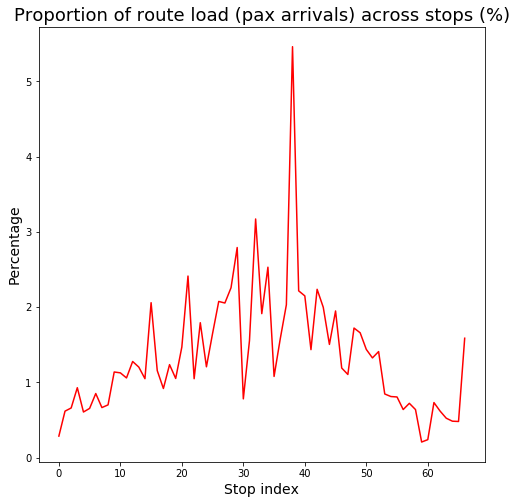

In [406]:
# this block explains how current passenger demand distribution is set up
# assume a diametrical route with loads normal distributed across the route
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ps=[]
for i in range(len(stop_pos)):
    if i != len(stop_pos)-1:
        p = pax_norm.cdf(stop_pos[i] + np.diff(stop_pos)[i]) - pax_norm.cdf(stop_pos[i]) ### a temporary measure ###
        ps.append(p*100)
ax.plot(range(len(stop_pos)-1), ps, 'r-')
plt.title("Proportion of route load (pax arrivals) across stops (%)", fontsize=18)
plt.xlabel("Stop index", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
plt.show()

[Passenger Arrival Rates at Public Transport Stations](http://www.andynash.com/nash-publications/Luethi2007-pax-arrivals-TRB-paper.pdf)

In [337]:
### outdated ###

# function for plotting time-space diagram
def plot_tsd(vehicles, start_sec=None, end_sec=None, save=False, fname='TSD'):
    """
    Plot the time-space diagram for a given dataframe containing
    real-time MTA bus data (as generated from fetchbus.py)
    PARAMETERS
    ----------
    vehicles: list
        Input a list of Bus objects.
    start_sec: numeric
        Plot from this given second (time elapsed).
    end_sec: numeric
        Plot until this given second (time elapsed).
    save: boolean
        Save TSD to .png at current directory.
    fname: string
        Assign a filename for saved TSD (otherwise may be overwritten).
        
    RETURNS
    -------
    fig:
    ax:
    filename.png: png
        a saved TSD file (optional)
    """
    # determine time interval to be plotted
    try:
        s = start_sec * 2 # * 60 sec / 30 sec interval
        e = end_sec * 2
    except:
        s = start_sec
        e = end_sec

    # plot figure
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    # plot the trajectory for each vehicle
    for i, v in enumerate(vehicles):
        # subset within specified time window
        traj = v.log_pos[s:e]
        
        # plot CallDistanceAlongRoute (bus stops)
#        [ax.plot([df['RecordedAtTime'].min(), df['RecordedAtTime'].max()], [i, i], color='gray', alpha=0.1) for i in df['CallDistanceAlongRoute'].unique()]
        
        ax.plot(range(len(traj)), traj, linestyle='-')
#        ax.annotate('%s'%v.split("_")[1], (list(veh_df['RecordedAtTime'])[0],list(veh_df['VehDistAlongRoute'])[0]))
        
#        ax.grid()
        ax.set_xlabel("time", fontsize=14)
        ax.set_ylabel("distance along route (m)", fontsize=14)
        ax.set_title("Time-space Diagram", fontsize=18)
    
    plt.tight_layout()
    
    # save figure locally if specified
    if save:
        plt.savefig("%s.png"%(fname), dpi=300)
    else:
        pass
    plt.show()
    
    return fig, ax

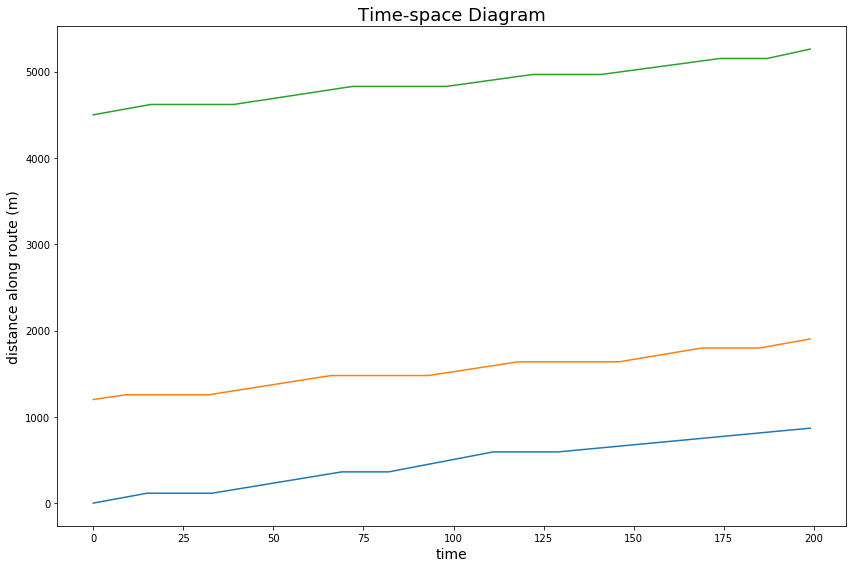

(<matplotlib.figure.Figure at 0x10f303048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1168064e0>)

In [338]:
plot_tsd(buses, end_sec=200)

In [ ]:
def draw(canvas):
    global time, started, score, lives, rock_group, my_ships
 
    # animiate background
    time += 1
    center = debris_info.get_center()
    size = debris_info.get_size()
    wtime = (time / 8) % center[0]
    canvas.draw_image(nebula_image, nebula_info.get_center(),
                      nebula_info.get_size(), [WIDTH / 2, HEIGHT / 2],
                      [WIDTH, HEIGHT])
    canvas.draw_image(debris_image, [center[0] - wtime, center[1]],
                      [size[0] - 2 * wtime, size[1]],
                      [WIDTH / 2 + 1.25 * wtime, HEIGHT / 2],
                      [WIDTH - 2.5 * wtime, HEIGHT])
    canvas.draw_image(debris_image, [size[0] - wtime, center[1]],
                      [2 * wtime, size[1]], [1.25 * wtime, HEIGHT / 2],
                      [2.5 * wtime, HEIGHT])

    # increase rock's velocity using score
    for rock in rock_group:
        for i in range(2):
            rock.vel[i] = rock.init_vel[i] + (rock.init_vel[i] * score * 0.03)

    # draw ship and sprites
    my_ship.draw(canvas)
    my_ship.update()
    process_sprite_group(rock_group, canvas)
    process_sprite_group(missile_group, canvas)
    process_sprite_group(explosion_group, canvas)

    # process collisions
    if group_collide(rock_group, my_ship):
        lives -= 1
    score += group_group_collide(missile_group, rock_group) * 10

    # check game status
    if lives == 0:
        rock_group = set()
        started = False

    # draw UI
    canvas.draw_text("Lives", [50, 60], 30, "white")

    # draw splash screen if not started
    if not started:
        canvas.draw_image(splash_image, splash_info.get_center(),
                          splash_info.get_size(), [WIDTH / 2, HEIGHT / 2],
                          splash_info.get_size())


# timer handler that spawns a rock
def rock_spawner():
    global rock_group, started
    if len(rock_group) > 12 or not started:
        return
    rock_vel = [random.random() * .6 - .3, random.random() * .6 - .3]
    rock_avel = random.random() * .2 - .1
    rock_pos = [random.randrange(0, WIDTH), random.randrange(0, HEIGHT)]
    # ensure rock_pos is at least 100px away of my_ship
    while dist(rock_pos, my_ship.pos) < 100:
        rock_pos = [random.randrange(0, WIDTH), random.randrange(0, HEIGHT)]
    # add rock to the group
    rock_group.add(Sprite(rock_pos, rock_vel, 0, rock_avel,
                          asteroid_image, asteroid_info))
    
# rock_group = set()
# missile_group = set()

In [ ]:
def hello():
    print "hello, world"

t = Timer(30.0, hello)
t.start() # after 30 seconds, "hello, world" will be printed

In [ ]:
class Bus:
    __capacity = Max Passengers
    __passengers = {} # Key on the passenger name

# In your addPassenger method, you need to make sure you haven't reached your "capacity".
# If you have, raise an exception. Also ensure the parameter is type checked and only allows Passenger objects.


# atstop = dict()
# bus1.atstop = False
# bus2.atstop = True
# bus3.atstop = False
# if len(check_atstop(buses)) > 0:
#     pass